# Analysis of Askreddit Database with the the help of Python 

In this Notebook, we present some SQL queries with their results, and the methods we've implemented to effeciently interpret the results.  

### 1) Importing Packages and Database 

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
conn = sqlite3.connect('C:/Users/mirar/Desktop/Data Bases/sqlite-tools-win32-x86-3340000/sqlite-tools-win32-x86-3340000/askreddit_data.db')
c = conn.cursor()


### 2) First Analysis with SQL queries 

##### What is the distribution of the score ?

In [3]:
scores = '''SELECT s.score FROM score as s'''
scores = c.execute(scores).fetchall()
scores = pd.DataFrame(scores)
scores.head()

,0
0,3
1,3
2,5
3,1
4,101


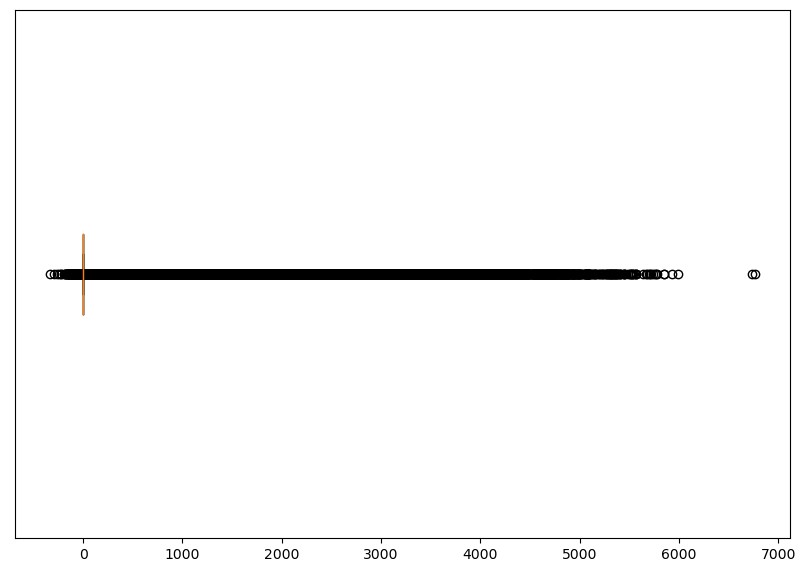

In [25]:
fig = plt.figure(figsize =(10, 7))
  
# Creating plot
plt.boxplot(scores,vert=False)
plt.yticks([], [])
plt.savefig('Boxplot-score.png')

# show plot
plt.show()

In [5]:
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

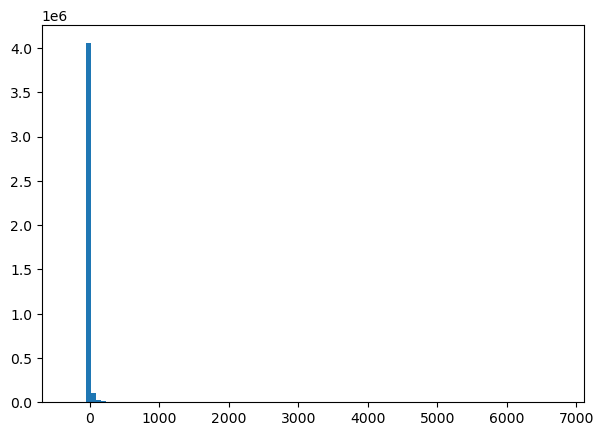

In [17]:
# Plot Histogram for the scores 

 plt.hist(scores, bins=50)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');

##### What is the distribution of the Number of Comments per author ?

We first start by getting the count of Number of comments per author 

In [27]:
active = '''SELECT COUNT(com.id) as num_comments_per_author, a.author
	FROM "comment" as com, author as a
	WHERE a.author = com.author
	AND com.author <> "[deleted]"
	GROUP BY a.author
	ORDER BY COUNT(com.id) DESC;'''
active = c.execute(active).fetchall()


In [29]:
active= pd.DataFrame(active)
active

,0,1
0,36910,AutoModerator
1,8298,Late_Night_Grumbler
2,5843,BiagioLargo
3,2989,-_-Equinox666-_-
4,2601,KubrickIsMyCopilot
...,...,...
570729,1,-----_____-----_____
570730,1,-----M3E46-----
570731,1,-----Batman-----
570732,1,------1


Then we sort the authors by the number of comments they contributed

In [30]:
active.columns = ["Count","User"]
active

,Count,User
0,36910,AutoModerator
1,8298,Late_Night_Grumbler
2,5843,BiagioLargo
3,2989,-_-Equinox666-_-
4,2601,KubrickIsMyCopilot
...,...,...
570729,1,-----_____-----_____
570730,1,-----M3E46-----
570731,1,-----Batman-----
570732,1,------1


Then we move to plotting the distibution of the number of comments per author 

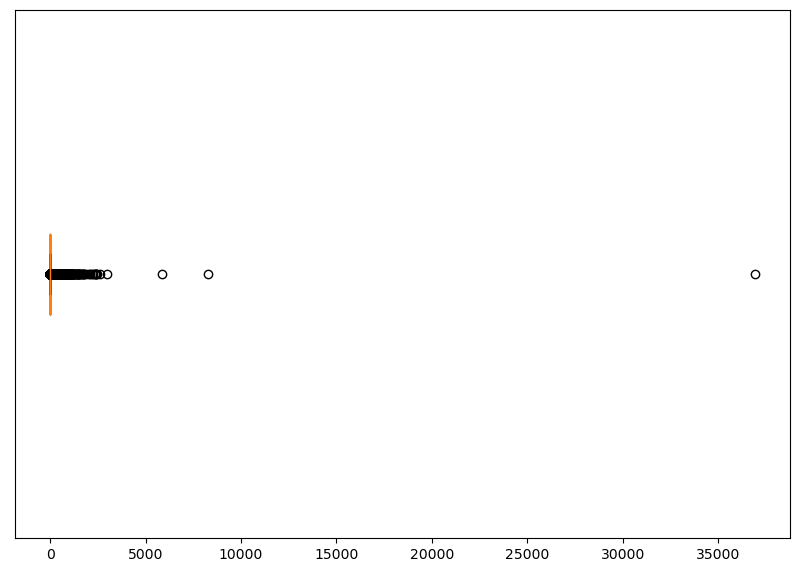

In [31]:
fig = plt.figure(figsize =(10, 7))
  
# Creating plot
plt.boxplot(active['Count'],vert=False)
plt.yticks([], [])
plt.savefig('boxcomments.png')
# show plot
plt.show()

##### What is the Distibution of Scores and Comments across time ? 

Here, we are interested in seeing:
    
    - The Average Score of Comments 
    - The total number of comments 
    - The Number of Gilded Comments 
    - The Number of Controversial Comments 

In [64]:
time = '''SELECT strftime('%w',DATETIME(c.created_utc,'unixepoch')) as Weekday,
	AVG(s.score) as score,
	COUNT(c.id) as Total_Comments,
	SUM(s.gilded),
	SUM(c.controversiality)
	FROM "comment" as c, score as s
	WHERE s.id = c.id
	GROUP BY Weekday;'''
time = c.execute(time).fetchall()

In [65]:
time = pd.DataFrame(time)
time.columns = ["Weekday","Avg_Score","Total_Comments","Gilded", "Controversiality"]
time

,Weekday,Avg_Score,Total_Comments,Gilded,Controversiality
0,0,13.003569,577212,404,8960
1,1,14.094373,511811,334,5892
2,2,12.455704,587430,333,7108
3,3,12.882324,623035,564,8301
4,4,12.577249,634516,517,7882
5,5,11.059402,760509,536,7037
6,6,12.828540,540457,626,7038


Plotting the Results related to the number of comments and the scores 

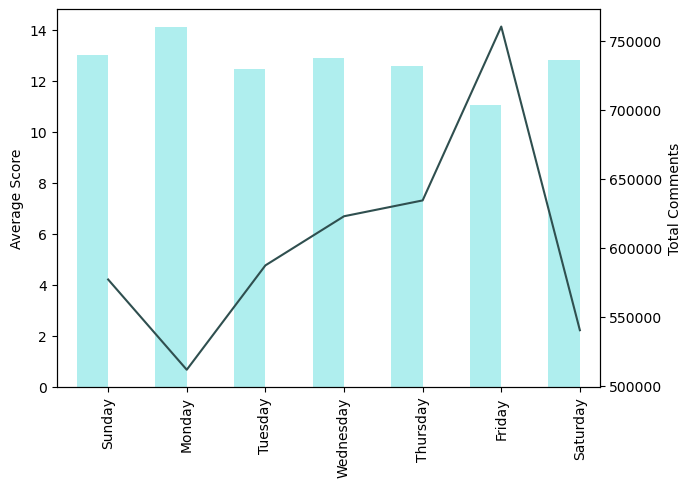

In [63]:
x = np.arange(len(time['Weekday'])) # the label locations
width = 0.35  # the width of the bars

fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

time.Avg_Score.plot(kind='bar', color='paleturquoise', ax=ax, width=width, position=1)
time.Total_Comments.plot(kind='line', color='darkslategrey', ax=ax2)

ax.set_ylabel('Average Score')
ax2.set_ylabel('Total Comments')
a=ax.get_xticks().tolist()
a[0]="Sunday"
a[1]="Monday"
a[2]="Tuesday"
a[3]="Wednesday"
a[4]="Thursday"
a[5]="Friday"
a[6]="Saturday"
ax.set_xticklabels(a)

plt.savefig('weekday.png')
plt.show()


Plotting the results for the number of Contreversial and Gilded comments 

<ipython-input-85-e632cafc0a89>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(a)


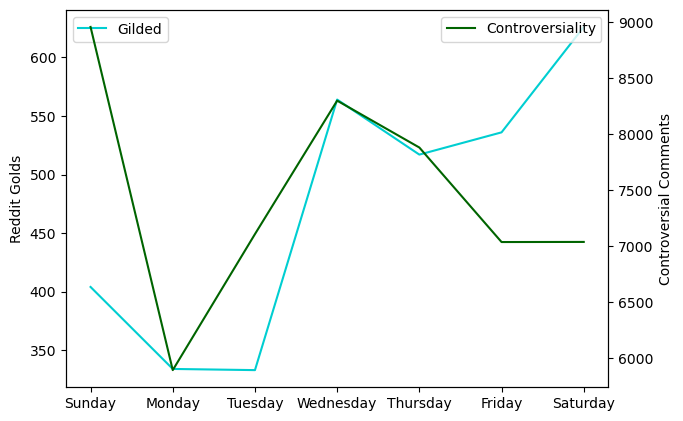

In [85]:
x = np.arange(len(time['Weekday'])) # the label locations
width = 0.35  # the width of the bars

fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

time.Gilded.plot(kind='line', color='darkturquoise', ax=ax)
time.Controversiality.plot(kind='line', color='darkgreen', ax=ax2)

ax.set_ylabel('Reddit Golds')
ax2.set_ylabel('Controversial Comments')

a=ax.get_xticks().tolist()
a[0]="Sunday"
a[1]="Sunday"
a[2]="Monday"
a[3]="Tuesday"
a[4]="Wednesday"
a[5]="Thursday"
a[6]="Friday"
a[7]="Saturday"

ax.set_xticklabels(a)
ax.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.savefig('weekdaygc.png')
plt.show()

##### What are the comments with the highest scores talking about ?

We first look at the comments of the comments with the highest scores 

In [144]:
top_10 = '''SELECT top_10.id, top_10.score, com.'body'
	FROM (SELECT com.id, s.score
			FROM "comment" as com, score as s
			WHERE s.id = com.id 
			ORDER BY s.score DESC
			LIMIT 20) as top_10, "comment" as com, score as s, is_distinguished as d
	WHERE s.id = top_10.id 
	AND com.id = top_10.id 
	AND d.id = top_10.id
	ORDER BY top_10.score DESC;'''
top_10 = c.execute(top_10).fetchall()
top_10

[('cr56nez', 6761, 'Then you got yourself a one night standoff.'),
 ('cr5gn52',
  6736,
  "if it's untreated wood...\n\ncut into 365 pieces, grind into powder and mix up in some oatmeal for an extra fiber filled punch.\n\nif it's treated wood fuck you, you eat it.\n\n\n\n\nedit:  thank you for the gold, i'll use it to buy a year's supply of fancy oatmeal."),
 ('cr3imvn',
  5992,
  "I have family who sailed around the world. One day in the North Atlantic, their sailboat was going over some GIGANTIC swells. They didn't have breaks at the top, so it was safe, but the boat was rising and falling way beyond  the neutral. \n\nAt the bottom of a trough my uncle looked up to see the sun behind a wave and the silhouette of a whale inside, above him. "),
 ('cr8p5z9',
  5927,
  'My boss is this giddy Asian lady (I work at a restaurant) and one day somehow we are on the subject of racial slurs. I am black and tell her I have been called "nigger" before in  a fight. She then asks me what the "Asian

We decide to do a word cloud for a better visualization 

In [158]:
# We Start with loading all necessary libraries
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
import re
%matplotlib inline


In [145]:
top_10 = pd.DataFrame(top_10)
top_10
top_10.columns = ["id","score","body"]
top_10

,id,score,body
0,cr56nez,6761,Then you got yourself a one night standoff.
1,cr5gn52,6736,if it's untreated wood...\n\ncut into 365 piec...
2,cr3imvn,5992,I have family who sailed around the world. One...
3,cr8p5z9,5927,My boss is this giddy Asian lady (I work at a ...
4,cqxx3fj,5849,Thanks man and also fuck you man
5,crl2axg,5845,This happened in med school. I was taking the...
6,cr8nddw,5776,"We had an office picture day. At the time, I w..."
7,cr5gmqg,5767,OP are you alright? I can send you food if you...
8,crmqs3w,5762,So she's pregnant huh
9,crih4mb,5741,Once as a tired medical resident I was called ...


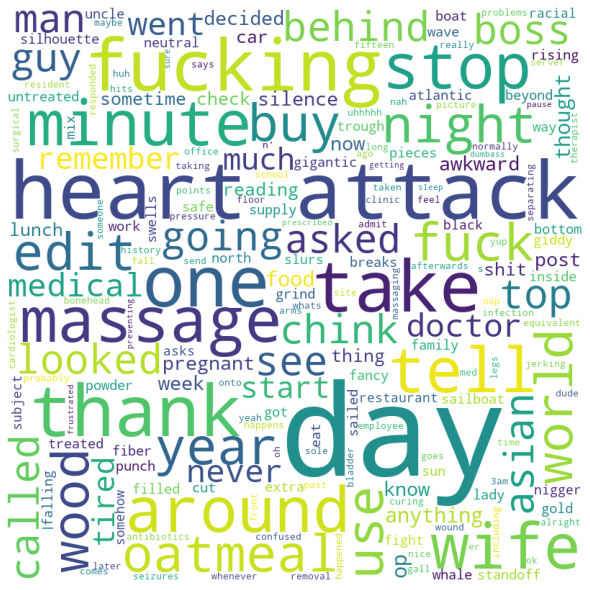

In [146]:
comment_words = ''

# iterate through the csv file
for val in top_10.body:
      
    # typecaste each val to string
    val = str(val)
    # Clean text
    val = re.sub(r'==.*?==+', '', val)
    val = val.replace('\n', '')
  
    # split the value
    tokens = val.split()
      
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
      
    comment_words += " ".join(tokens)+" "
    
  
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
  
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.savefig('wordcloud.png')
  
plt.show()

### 3) Analysis with SQL queries on the set containing the 7 top most active users 

We start by taking the 7 most active users 

In [155]:
most_active = '''SELECT com.id, com.'body', com.author, com.controversiality, com.edited,
	   s.score, s.gilded, s.score_hidden, d.distinguished, dep.parent_id
	FROM "comment" as com, score as s, is_distinguished as d, depends as dep,
		(SELECT com.author as name
			FROM "comment" as com 
			WHERE com.author <> "AutoModerator" 
			AND com.author <> "[deleted]"
			GROUP BY com.author
			ORDER BY COUNT(com.id) DESC 
			LIMIT 7) as int_users
	WHERE s.id = com.id 
	AND dep.id = com.id
	AND d.id = com.id 
	AND com.author = int_users.name; '''
most_active = c.execute(most_active).fetchall()

##### What are the main characteristics of the comments of these users ?

In [156]:
most_active = pd.DataFrame(most_active)
most_active

,0,1,2,3,4,5,6,7,8,9
0,cqug9wo,"You can run and hide, but it's moot. He's alre...",Late_Night_Grumbler,0,0,1,0,0,,t1_cqug7jv
1,cquga9a,You had your chance.,Late_Night_Grumbler,0,0,0,0,0,,t1_cqug923
2,cqugb9u,What's momos?,Late_Night_Grumbler,0,0,2,0,0,,t3_34gn25
3,cqugbkd,There won't be a next time.\n\nShhh...,Late_Night_Grumbler,0,0,0,0,0,,t1_cqugb4z
4,cqugc6i,I did.,Late_Night_Grumbler,0,0,1,0,0,,t3_34gmvf
...,...,...,...,...,...,...,...,...,...,...
26972,crrbclb,color me impressed. although it's pretty saw 1...,BiagioLargo,0,0,1,0,0,,t1_crrav0p
26973,crrbdeq,A potato peeler. Time to julienne me some zomb...,Late_Night_Grumbler,0,0,4,0,0,,t3_380nob
26974,crrbdk9,"Never heard any Margaret Thatcher speeches, or...",KubrickIsMyCopilot,0,0,0,0,0,,t1_crrb9gh
26975,crrbdnv,Soda.,Late_Night_Grumbler,0,0,1,0,0,,t3_380nra


In [157]:
most_active.columns = ["id","body","author","controversiality", "edited", "score","gilded","score_h","distinguished","parent_id"]
most_active

,id,body,author,controversiality,edited,score,gilded,score_h,distinguished,parent_id
0,cqug9wo,"You can run and hide, but it's moot. He's alre...",Late_Night_Grumbler,0,0,1,0,0,,t1_cqug7jv
1,cquga9a,You had your chance.,Late_Night_Grumbler,0,0,0,0,0,,t1_cqug923
2,cqugb9u,What's momos?,Late_Night_Grumbler,0,0,2,0,0,,t3_34gn25
3,cqugbkd,There won't be a next time.\n\nShhh...,Late_Night_Grumbler,0,0,0,0,0,,t1_cqugb4z
4,cqugc6i,I did.,Late_Night_Grumbler,0,0,1,0,0,,t3_34gmvf
...,...,...,...,...,...,...,...,...,...,...
26972,crrbclb,color me impressed. although it's pretty saw 1...,BiagioLargo,0,0,1,0,0,,t1_crrav0p
26973,crrbdeq,A potato peeler. Time to julienne me some zomb...,Late_Night_Grumbler,0,0,4,0,0,,t3_380nob
26974,crrbdk9,"Never heard any Margaret Thatcher speeches, or...",KubrickIsMyCopilot,0,0,0,0,0,,t1_crrb9gh
26975,crrbdnv,Soda.,Late_Night_Grumbler,0,0,1,0,0,,t3_380nra


##### What are these users talking about ?

In [159]:
#Similarly we want to do a word cloud 
comment_words = ''

In [160]:
# iterate through the csv file
for val in most_active.body:
      
    # typecaste each val to string
    val = str(val)
    # Clean text
    val = re.sub(r'==.*?==+', '', val)
    val = val.replace('\n', '')
  
    # split the value
    tokens = val.split()
      
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
      
    comment_words += " ".join(tokens)+" "


In [161]:
comment_words

'you can run and hide, but it\'s moot. he\'s already there. knock, knock. think twice about opening your front door. you had your chance. what\'s momos? there won\'t be a next time.shhh... i did. you can\'t tell my penis what to do! don\'t eat that soup. i don\'t know. didn\'t flatter me? yeah, sounds right. apostrophes are not used for pluralization! they should use the bathroom they find appropriate. *zips my pants up.*i\'ll pay for that. 24/7 access to boobs! fuck you. now i\'m definitely not going to talk to you! *punches through your face.* how did you find that? you\'re right. i\'ll tell him to use your tears as lube. you should underestimate me when challenged. pull out the diaper i brought just for this occasion. what ship classification is the valdemar? you should see someone about your damaged peepee. you should see someone about your damaged peepee. i was helping you suffer less and this is how you repay me?! i pay my bills, go to work, act responsible, and only play in the 

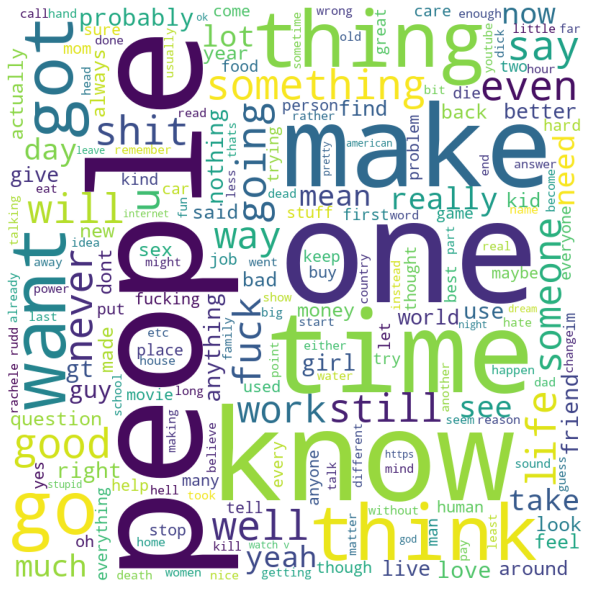

In [171]:
  wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
  
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.savefig('final.png')
  
plt.show()